![BTS](https://github.com/vfp1/bts-dsf-2020/blob/main/Logo-BTS.jpg?raw=1)

# Session 6: Image processing - NumPy/SciPy cted & Scikit image

### Victor F. Pajuelo Madrigal <victor.pajuelo@bts.tech> - Data Science Foundations (2020-11-05)

Open this notebook in Google Colaboratory: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vfp1/bts-dsf-2020/blob/main/Session_6/06_Image_processing.ipynb)

**Resources:**

* [SciPy](https://scipy.org)
* [Scipy Lectures](https://scipy-lectures.org)
* [NumPy](https://numpy.org)

# CONTINUATION - Basic image manipulation in Python: NumPy and Scipy

Image can be understood as a 2D numerical array. Or 3D such as RGB, or MRI, etc. From now on, we will understand **image==np.array**

We will be using basically `numpy` for basic array manipulation and `scipy` with its `ndimage` submodule dedicated for image processing of n-dimensional images.


## Common tasks in image processing

* Input/Output, displaying images
* Basic manipulations: cropping, flipping, rotating, …
* Image filtering: denoising, sharpening
* Image segmentation: labeling pixels corresponding to different objects
* Classification
* Feature extraction
* Registration
* …

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import imageio

## Excursus about dimensions

The shape of NumPy arrays can be confusing. The axis 0, runs alongside x, while axis 1 runs alongside y. In this case, the image below, Numpy is telling us that we have 768 rows in the axis 0, 1024 rows on the axis 1 and 3 bands.

This is because in NumPy indexing, the first dimension (`array.shape[0]`) corresponds to rows, while the second (`array.shape[1]`) corresponds to columns, with the origin (`array[0, 0]`) at the top-left corner. This matches matrix/linear algebra notation, but is in contrast to Cartesian (x, y) coordinates. 

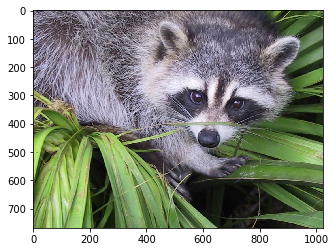


 (768, 1024, 3) uint8


In [3]:
import imageio
from scipy import misc

f = misc.face()
imageio.imwrite('face.jpg', f)

import matplotlib.pyplot as plt
plt.imshow(f)
plt.show()

face = imageio.imread('face.jpg')
type(face)

print("\n", face.shape, face.dtype)

### Another example

(200, 400, 3)


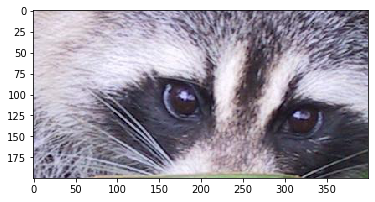

In [4]:
import matplotlib.pyplot as plt

f = face[200:400, 400:800]

print(f.shape)

plt.imshow(face[200:400, 400:800])
plt.show()

## Filters: convolutions, low pass, high pass, directional pass

### Convolutions or filters

In mathematics (in particular, functional analysis) convolution is a mathematical operation on two functions (f and g) that produces a third function expressing how the shape of one is modified by the other. The term convolution refers to both the result function and to the process of computing it. It is defined as the integral of the product of the two functions after one is reversed and shifted.

A very detail explanation [here](https://stackoverflow.com/questions/20036663/understanding-numpys-convolve):

Convolution is a mathematical operator primarily used in signal processing. Numpy simply uses this signal processing nomenclature to define it, hence the "signal" references. An array in numpy is a signal. **The convolution of two signals is defined as the integral of the first signal, reversed, sweeping over ("convolved onto") the second signal and multiplied (with the scalar product) at each position of overlapping vectors**. The first signal is often called the kernel, especially when it is a 2-D matrix in image processing or neural networks, and the reversal becomes a mirroring in 2-D (NOT transpose). It can more clearly be understood using the animations on wikipedia.

![alt text](https://upload.wikimedia.org/wikipedia/commons/6/6a/Convolution_of_box_signal_with_itself2.gif)

![alt text](https://upload.wikimedia.org/wikipedia/commons/b/b9/Convolution_of_spiky_function_with_box2.gif)

Convolution filter:

![alt text](https://icecreamlabs.com/wp-content/uploads/2018/08/33-con.gif)

Kernel operation:
![alt text](https://miro.medium.com/max/1050/1*ptkQvYLjOrXXvP7BrKG0lA.gif)

But hey!! What do we do with the edges of the image and the kernel? Well, there are different strategies. This is what we call **edge handling**, and there is a variety of methods to handle the edges:

* **Extend**: the nearest border pixels are conceptually extended as far as necessary to provide values for the convolution. Corner pixels are extended in 90° wedges. Other edge pixels are extended in lines.
* **Wrap**: the image is conceptually wrapped (or tiled) and values are taken from the opposite edge or corner.
* **Mirror**: the image is conceptually mirrored at the edges. For example, attempting to read a pixel 3 units outside an edge reads one 3 units inside the edge instead.
* **Crop**: any pixel in the output image which would require values from beyond the edge is skipped. This method can result in the output image being slightly smaller, with the edges having been cropped.
* Kernel Crop: ny pixel in the kernel that extends past the input image isn't used and the normalizing is adjusted to compensate.

### Using your own kernels in scipy

We can use `ndimage.convolve` which has a variety of modes to deal with the edges. Usually, the best is to set the values out of the image to a value (cval) of 0. 

In [5]:
from scipy import ndimage


a = np.array([[1, 2, 0, 0],[5, 3, 0, 4],[0, 0, 0, 7], [9, 3, 0, 0]])


k = np.array([ [1,1,1], [1,1,0], [1,0,0] ])

ndimage.convolve(a, k, mode='constant', cval=0.0)

array([[11, 10,  7,  4],
       [10,  3, 11, 11],
       [15, 12, 14,  7],
       [12,  3,  7,  0]])

#### Identity filter
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/5bf6623ca763ba780b471a565eb1b06cd14b445c)

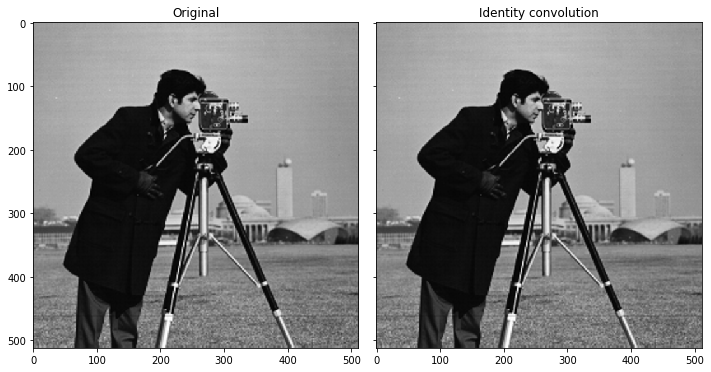

In [6]:
import imageio
from scipy import ndimage
import matplotlib.pyplot as plt

from skimage.data import camera

image = camera()

kernel = np.array([ [0,0,0], 
                    [0,1,0], 
                    [0,0,0]]) 

filtered = ndimage.convolve(image, kernel, mode='constant', cval=0.0)

fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,
                       figsize=(10, 10))

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')

ax[1].imshow(filtered, cmap=plt.cm.gray)
ax[1].set_title('Identity convolution')

plt.tight_layout()
plt.show()

### Low pass filtering
A low pass filter is the basis for most smoothing methods. An image is smoothed by decreasing the disparity between pixel values by averaging nearby pixels.

Using a low pass filter tends to retain the low frequency information within an image while reducing the high frequency information. An example is an array of ones divided by the number of elements within the kernel, such as the following 3 by 3 kernel:

![alt text](https://northstar-www.dartmouth.edu/doc/idl/html_6.2/images/Filtering_an_Image-45.jpg)



#### Box blur
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/f1e6d5ec15af752f471372b96a1be4a83e02873e)

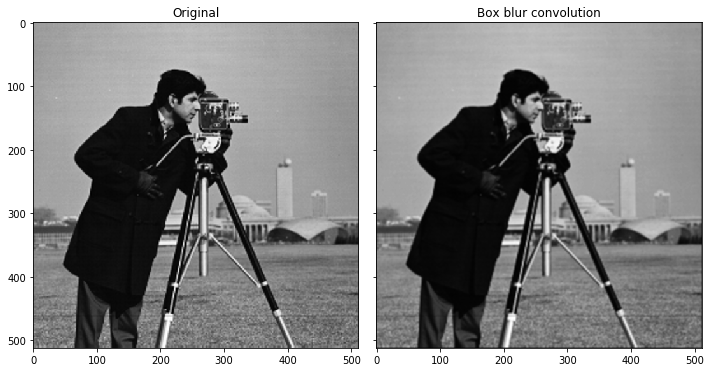

In [7]:
import imageio
from scipy import ndimage
import matplotlib.pyplot as plt

from skimage.data import camera

image = camera()

kernel = np.array([ [1/9,1/9,1/9], 
                    [1/9,1/9,1/9], 
                    [1/9,1/9,1/9]]) 

filtered = ndimage.convolve(image, kernel, mode='constant', cval=0.0)

fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,
                       figsize=(10, 10))

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')

ax[1].imshow(filtered, cmap=plt.cm.gray)
ax[1].set_title('Box blur convolution')

plt.tight_layout()
plt.show()

#### Gaussian blur 3x3
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/c1e0a314554ab3663f129961ebd28fec307e74c4)

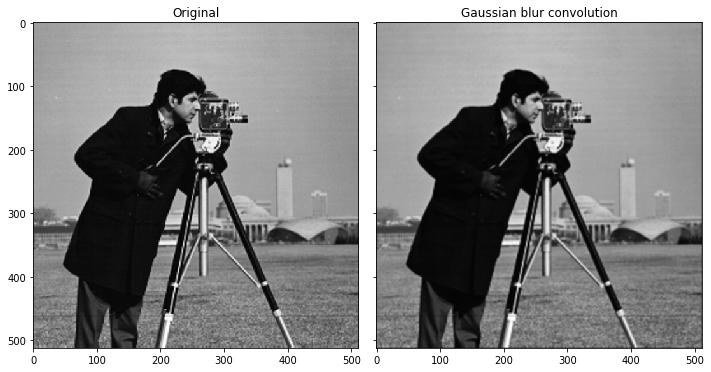

In [8]:
import imageio
from scipy import ndimage
import matplotlib.pyplot as plt

from skimage.data import camera

image = camera()

kernel = np.array([ [1/16,2/16,1/16], 
                    [2/16,4/16,2/16], 
                    [1/16,2/16,1/16]]) 

filtered = ndimage.convolve(image, kernel, mode='constant', cval=0.0)

fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,
                       figsize=(10, 10))

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')

ax[1].imshow(filtered, cmap=plt.cm.gray)
ax[1].set_title('Gaussian blur convolution')

plt.tight_layout()
plt.show()

#### Gaussian blur 5x5
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/f91401a3e97428f14862afa1c781c55f4157580b)

[[0.0001 0.0004 0.0006 0.0004 0.0001]
 [0.0004 0.0016 0.0024 0.0016 0.0004]
 [0.0006 0.0024 0.0036 0.0024 0.0006]
 [0.0004 0.0016 0.0024 0.0016 0.0004]
 [0.0001 0.0004 0.0006 0.0004 0.0001]]


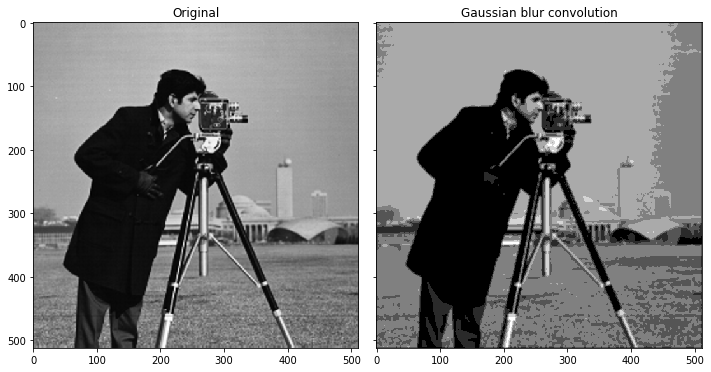

In [9]:
import imageio
from scipy import ndimage
import matplotlib.pyplot as plt

from skimage.data import camera

image = camera()

kernel = 1/10000*np.array([ [1, 4, 6, 4, 1], 
                        [4, 16, 24, 16, 4], 
                        [6, 24, 36, 24, 6],
                        [4, 16, 24, 16, 4],
                        [1, 4, 6, 4, 1]]) 

print(kernel)

filtered = ndimage.convolve(image, kernel, mode='constant', cval=0.0)

fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,
                       figsize=(10, 10))

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')

ax[1].imshow(filtered, cmap=plt.cm.gray)
ax[1].set_title('Gaussian blur convolution')

plt.tight_layout()
plt.show()

### High pass filtering
A high pass filter is the basis for most sharpening methods. An image is sharpened when contrast is enhanced between adjoining areas with little variation in brightness or darkness 

A high pass filter tends to retain the high frequency information within an image while reducing the low frequency information. The kernel of the high pass filter is designed to increase the brightness of the center pixel relative to neighboring pixels. The kernel array usually contains a single positive value at its center, which is completely surrounded by negative values. The following array is an example of a 3 by 3 kernel for a high pass filter:

![alt text](https://northstar-www.dartmouth.edu/doc/idl/html_6.2/images/Filtering_an_Image-46.jpg)

#### High frequency extraction (edges)


[[-0.11111111 -0.11111111 -0.11111111]
 [-0.11111111  0.88888889 -0.11111111]
 [-0.11111111 -0.11111111 -0.11111111]]


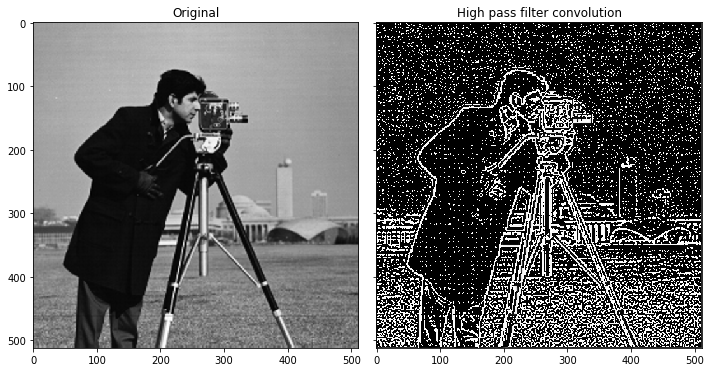

In [10]:
import imageio
from scipy import ndimage
import matplotlib.pyplot as plt

from skimage.data import camera

image = camera()

kernel = np.array([ [-1, -1, -1], 
                    [-1, 8, -1], 
                    [-1, -1, -1]]) / 9

print(kernel)

filtered = ndimage.convolve(image, kernel, mode='constant', cval=0.0)

fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,
                       figsize=(10, 10))

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')

ax[1].imshow(filtered, cmap=plt.cm.gray)
ax[1].set_title('High pass filter convolution')

plt.tight_layout()
plt.show()

#### Sharpen image

Welcome to aliasing and other artifacts!

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/beb8b9a493e8b9cf5deccd61bd845a59ea2e62cc)

[[ 0 -1  0]
 [-1  5 -1]
 [ 0 -1  0]]


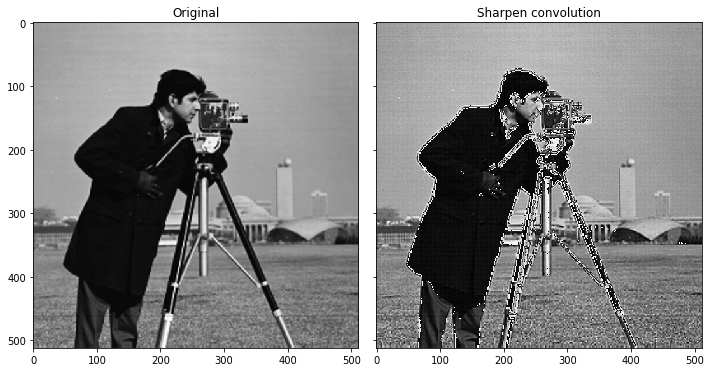

In [11]:
import imageio
from scipy import ndimage
import matplotlib.pyplot as plt

from skimage.data import camera

image = camera()

kernel = np.array([ [0, -1, 0], 
                    [-1, 5, -1], 
                    [0, -1, 0]])

print(kernel)

filtered = ndimage.convolve(image, kernel, mode='mirror', cval=0.0)

fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,
                       figsize=(10, 10))

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')

ax[1].imshow(filtered, cmap=plt.cm.gray)
ax[1].set_title('Sharpen convolution')

plt.tight_layout()
plt.show()

### Directional filtering: edge detection

A directional filter forms the basis for some edge detection methods. An edge within an image is visible when a large change (a steep gradient) occurs between adjacent pixel values. This change in values is measured by the first derivatives (often referred to as slopes) of an image. Directional filters can be used to compute the first derivatives of an image.

The following array is an example of a 3 by 3 kernel for an x-directional filter (the kernel for the y-direction is the transpose of this kernel):

![alt text](https://northstar-www.dartmouth.edu/doc/idl/html_6.2/images/Filtering_an_Image-47.jpg)

#### Vertical filter

[[-1  0  1]
 [-1  0  1]
 [-1  0  1]]


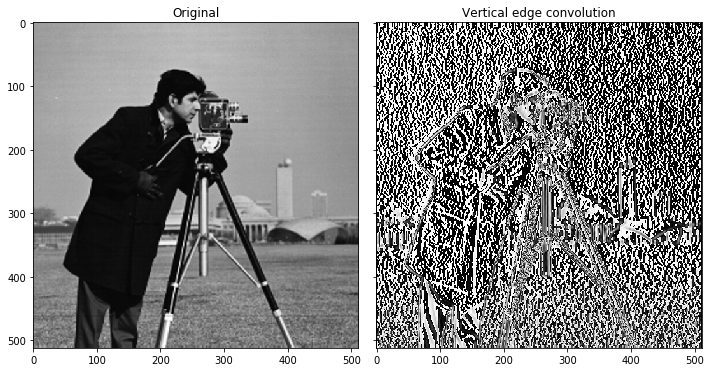

In [12]:
import imageio
from scipy import ndimage
import matplotlib.pyplot as plt

from skimage.data import camera

image = camera()

kernel = np.array([ [-1, 0, 1], 
                    [-1, 0, 1], 
                    [-1, 0, 1]])

print(kernel)

filtered = ndimage.convolve(image, kernel, mode='mirror', cval=0.0)

fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,
                       figsize=(10, 10))

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')

ax[1].imshow(filtered, cmap=plt.cm.gray)
ax[1].set_title('Vertical edge convolution')

plt.tight_layout()
plt.show()

#### Horizontal filter

[[ 1  1  1]
 [ 0  0  0]
 [-1 -1 -1]]


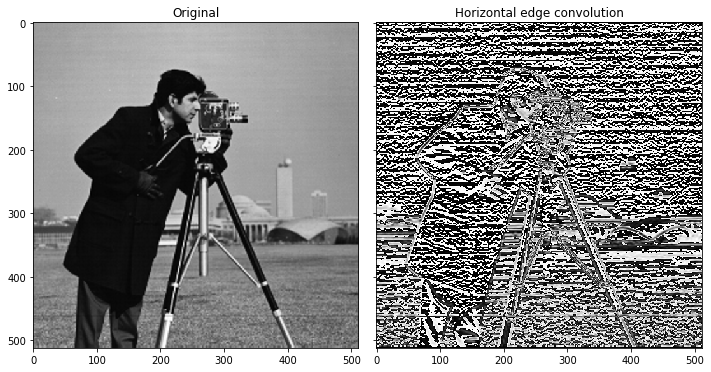

In [13]:
import imageio
from scipy import ndimage
import matplotlib.pyplot as plt

from skimage.data import camera

image = camera()

kernel = np.array([ [1, 1, 1], 
                    [0, 0, 0], 
                    [-1, -1, -1]])

print(kernel)

filtered = ndimage.convolve(image, kernel, mode='mirror', cval=0.0)

fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,
                       figsize=(10, 10))

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')

ax[1].imshow(filtered, cmap=plt.cm.gray)
ax[1].set_title('Horizontal edge convolution')

plt.tight_layout()
plt.show()

#### Edge detection v1
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/548cba0e0cbc6afb1a43ea75c806079910b34c3e)

[[ 1  0 -1]
 [ 0  0  0]
 [-1  0  1]]


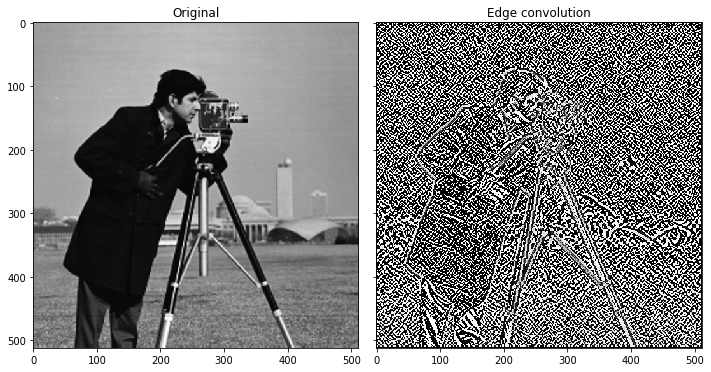

In [14]:
import imageio
from scipy import ndimage
import matplotlib.pyplot as plt

from skimage.data import camera

image = camera()

kernel_edge = np.array([ [1, 0, -1], 
                       [0, 0, 0], 
                        [-1, 0, 1]])

print(kernel_edge)

edge = ndimage.convolve(image, kernel_edge, mode='mirror', cval=0.0)

fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,
                       figsize=(10, 10))

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')

ax[1].imshow(edge, cmap=plt.cm.gray)
ax[1].set_title('Edge convolution')

plt.tight_layout()
plt.show()

### Kernel combinations: gaussian + edge

2


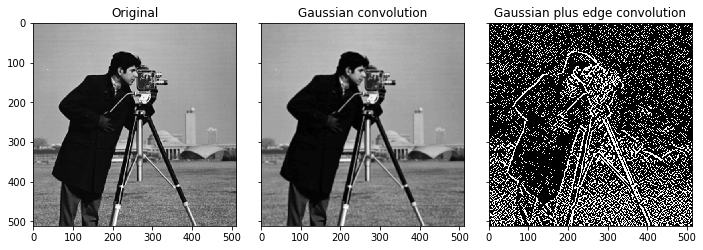

In [15]:
import imageio
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt

from skimage.data import camera

image = camera()

kernel_gaussian = 1/1024*np.array([ [1, 4, 6, 4, 1], 
                        [4, 16, 24, 16, 4], 
                        [6, 24, 36, 24, 6],
                        [4, 16, 24, 16, 4],
                        [1, 4, 6, 4, 1]]) 

kernel_edge = np.array([ [1, 0, -1], 
                       [0, 0, 0], 
                        [-1, 0, 1]])

print(image.ndim)

filtered = ndimage.convolve(image, kernel_gaussian, mode='mirror', cval=0.0)
edge = ndimage.convolve(filtered, kernel_edge, mode='mirror', cval=0.0)

fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True,
                       figsize=(10, 10))

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')

ax[1].imshow(filtered, cmap=plt.cm.gray)
ax[1].set_title('Gaussian convolution')

ax[2].imshow(edge, cmap=plt.cm.gray)
ax[2].set_title('Gaussian plus edge convolution')

plt.tight_layout()
plt.show()

## In class exercises: filters

1. Try to combine different filters. Try to find edges by smoothing the image, 
applying a spatial filter and then a high pass filter to sharpen the edges.
2. Implement these filters, what are those? Low pass or spatial filters?

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/485992cb4024ac032e53eea37c24c30829cdfed6)

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/f800ad5f76b6c26c729ff0c1fef44284d7cade7a)



[[ 1  0 -1]
 [ 0  4  0]
 [-1  0  1]]


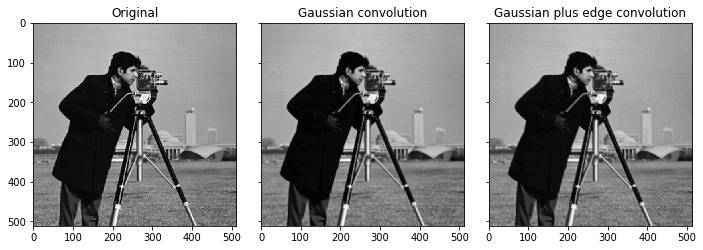

In [16]:
import numpy as np
import imageio
from scipy import ndimage
import matplotlib.pyplot as plt

from skimage.data import camera

image = camera()

kernel_gaussian = 1/1024*np.array([ [1, 4, 6, 4, 1], 
                        [4, 16, 24, 16, 4], 
                        [6, 24, 36, 24, 6],
                        [4, 16, 24, 16, 4],
                        [1, 4, 6, 4, 1]]) 

kernel_edge = np.array([ [1, 0, -1], 
                       [0, 4, 0], 
                        [-1, 0, 1]])

print(kernel_edge)

filtered = ndimage.convolve(image, kernel_gaussian, mode='mirror', cval=0.0)
edge = ndimage.convolve(filtered, kernel_edge, mode='mirror', cval=0.0)

fig, ax = plt.subplots(nrows =1, ncols=3, sharex=True, sharey=True,
                       figsize=(10, 10))

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')

ax[1].imshow(filtered, cmap=plt.cm.gray)
ax[1].set_title('Gaussian convolution')

ax[2].imshow(edge, cmap=plt.cm.gray)
ax[2].set_title('Gaussian plus edge convolution')

#ax[4].imshow(image, cmap=plt.cm.gray)
#ax[4].set_title('Original')

plt.tight_layout()
plt.show()

<class 'type'>
[[ 0  1  0]
 [ 1 -5  1]
 [ 0  1  0]]


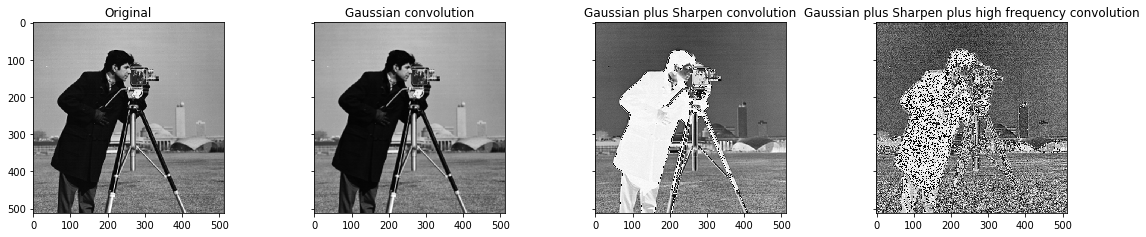

In [17]:
import numpy as np
import imageio
from scipy import ndimage
import matplotlib.pyplot as plt

from skimage.data import camera

image = camera()

kernel_gaussian = 1/16*np.array([ [1, 2, 1], 
                        [2, 4, 2], 
                        [1, 2, 1]]) 

print(type)
kernel_Sharpen = np.array([ [0, 1, 0], 
                       [1, -5, 1], 
                        [0, 1, 0]])

kernel_High_frequency = np.array([ [-1, -1, -1], 
                       [-1, 9, -1], 
                        [-1, -1, -1]])
smooth = True

print(kernel_Sharpen)
if smooth:
    filter_gaussian = ndimage.convolve(image, kernel_gaussian, mode='mirror', cval=0.0)
    filt_sharp = ndimage.convolve(filter_gaussian, kernel_Sharpen, mode='mirror', cval=0.0)
else:
    filt_sharp = ndimage.convolve(image, kernel_Sharpen, mode='mirror', cval=0.0)

filt_high_freq = ndimage.convolve(filt_sharp, kernel_High_frequency, mode='mirror', cval=0.0)

fig, ax = plt.subplots(nrows =1, ncols=4, sharex=True, sharey=True,
                       figsize=(16, 16))

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')

ax[1].imshow(filter_gaussian, cmap=plt.cm.gray)
ax[1].set_title('Gaussian convolution')

ax[2].imshow(filt_sharp, cmap=plt.cm.gray)
ax[2].set_title('Gaussian plus Sharpen convolution')

ax[3].imshow(filt_high_freq, cmap=plt.cm.gray)
ax[3].set_title('Gaussian plus Sharpen plus high frequency convolution')

#ax[4].imshow(image, cmap=plt.cm.gray)
#ax[4].set_title('Original')

plt.tight_layout()
plt.show()

## Mathematical morphology: filters for array manipulation

Mathematical morphology probes an image with a simple shape (a structuring element) and modifies the image according to how the shape locally fits or misses the image.

Mathematical morphology it is extremely useful to clean dirty data once we have a prediction, for instance using erosion or dilation.

In a nutshell, mathematical morphology works by passing the structuring element (3x3, 9x9) as a kernel over the image and applying certain functions. 

![alt text](http://www.dspguide.com/graphics/F_25_10.gif)

### Erosion

The 3×3 square of ones is probably the most common structuring element used in erosion operations, but others can be used. A larger structuring element produces a more extreme erosion effect, although usually very similar effects can be achieved by repeated erosions using a smaller similarly shaped structuring element. With larger structuring elements, it is quite common to use an approximately disk shaped structuring element, as opposed to a square one.

The erosion is then a minimum filter, it replaces the value of a pixel by the minimal value covered by the structuring element.

![alt text](https://homepages.inf.ed.ac.uk/rbf/HIPR2/figs/erodbin.gif)

The a value is 49
The a value is 49


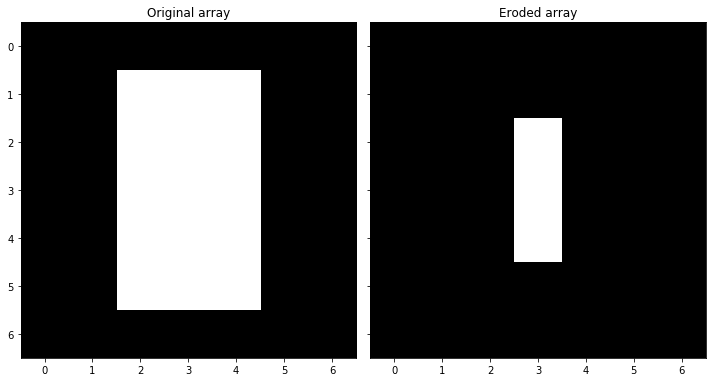

In [18]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

# Original array
a = np.zeros((7,7), dtype=np.int)
a[1:6, 2:5] = 1

print("The a value is {0}".format(a.size))
 # Erosion
e = ndimage.binary_erosion(a, structure=np.ones((3,3))).astype(a.dtype)
print("The a value is {0}".format(e.size))

# Plotting
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,
                       figsize=(10, 10))

ax[0].imshow(a, cmap=plt.cm.gray)
ax[0].set_title('Original array')

ax[1].imshow(e, cmap=plt.cm.gray)
ax[1].set_title('Eroded array')

plt.tight_layout()
plt.show()

### Dilation

The 3×3 square of ones is probably the most common structuring element used in dilation operations, but others can be used. A larger structuring element produces a more extreme dilation effect, although usually very similar effects can be achieved by repeated dilations using a smaller but similarly shaped structuring element. With larger structuring elements, it is quite common to use an approximately disk shaped structuring element, as opposed to a square one.

It works as a maximum filter.

![alt text](https://homepages.inf.ed.ac.uk/rbf/HIPR2/figs/diltbin.gif)

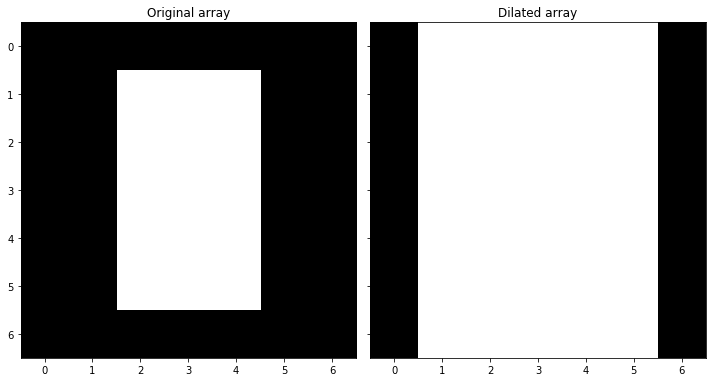

In [19]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

# Original array
a = np.zeros((7,7), dtype=np.int)
a[1:6, 2:5] = 1

 # Dilation
d = ndimage.binary_dilation(a, structure=np.ones((3,3))).astype(a.dtype)

# Plotting
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,
                       figsize=(10, 10))

ax[0].imshow(a, cmap=plt.cm.gray)
ax[0].set_title('Original array')

ax[1].imshow(d, cmap=plt.cm.gray)
ax[1].set_title('Dilated array')

plt.tight_layout()
plt.show()

### Opening: erosion + dilation

The structure kernel of binary opening, if we do not pass a matrix square of ones, it results to a sort of "cross". Which is useful to smooth images.

Structuring element used for the opening. Non-zero elements are considered True. If no structuring element is provided an element is generated with a square connectivity equal to one (i.e., only nearest neighbors are connected to the center, diagonally-connected elements are not considered neighbors).

![alt text](https://scipy-lectures.org/_images/diamond_kernel.png)

As with erosion and dilation, it is very common to use this 3×3 structuring element. The effect in the above figure is rather subtle since the structuring element is quite compact and so it fits into the foreground boundaries quite well even before the opening operation. To increase the effect, multiple erosions are often performed with this element followed by the same number of dilations. This effectively performs an opening with a larger square structuring element.

![alt text](https://homepages.inf.ed.ac.uk/rbf/HIPR2/figs/openbin.gif)

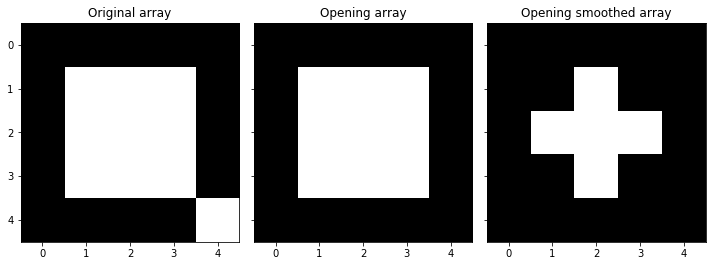

In [20]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

# Original array
a = np.zeros((5,5), dtype=np.int)
a[1:4, 1:4] = 1; a[4, 4] = 1

 # Opening
o = ndimage.binary_opening(a, structure=np.ones((3,3))).astype(a.dtype)

# Opening with "cross" kernel
oc = ndimage.binary_opening(a).astype(a.dtype)

# Plotting
fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True,
                       figsize=(10, 10))

ax[0].imshow(a, cmap=plt.cm.gray)
ax[0].set_title('Original array')

ax[1].imshow(o, cmap=plt.cm.gray)
ax[1].set_title('Opening array')

ax[2].imshow(oc, cmap=plt.cm.gray)
ax[2].set_title('Opening smoothed array')

plt.tight_layout()
plt.show()

### Closing: dilation + erosion
As with erosion and dilation, this particular 3×3 structuring element is the most commonly used, and in fact many implementations will have it hardwired into their code, in which case it is obviously not necessary to specify a separate structuring element. To achieve the effect of a closing with a larger structuring element, it is possible to perform multiple dilations followed by the same number of erosions.

Closing can sometimes be used to selectively fill in particular background regions of an image. Whether or not this can be done depends upon whether a suitable structuring element can be found that fits well inside regions that are to be preserved, but doesn't fit inside regions that are to be removed.

![alt text](https://homepages.inf.ed.ac.uk/rbf/HIPR2/figs/closebin.gif)

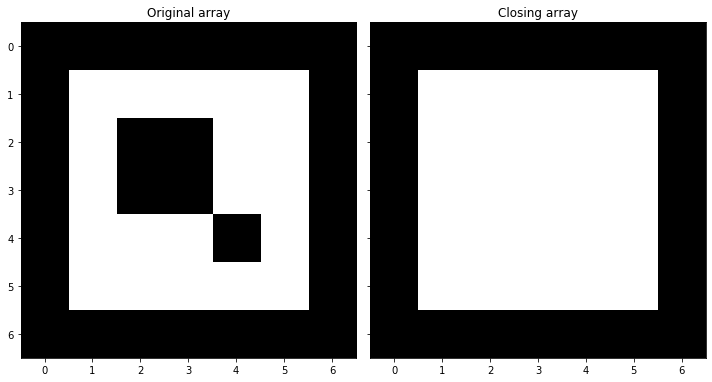

In [21]:
 import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

# Original array
a = np.zeros((7,7), dtype=np.int)
a[1:6, 1:6] = 1
a[2:4, 2:4] = 0
a[4:5, 4:5] = 0

 # Closing
o = ndimage.binary_closing(a, structure=np.ones((3,3))).astype(a.dtype)

# Plotting
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,
                       figsize=(10, 10))

ax[0].imshow(a, cmap=plt.cm.gray)
ax[0].set_title('Original array')

ax[1].imshow(o, cmap=plt.cm.gray)
ax[1].set_title('Closing array')

plt.tight_layout()
plt.show()

### Application: noise removal

After segmentation operations and inferences, mathematical morphology it is extremely useful for noise removal:

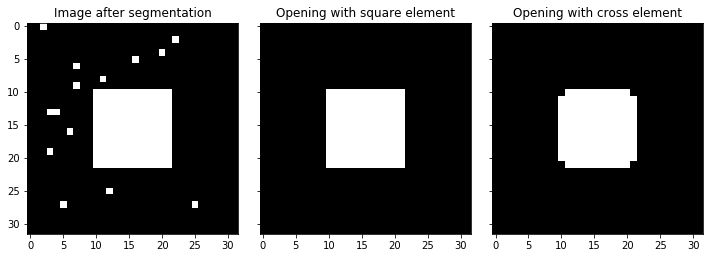

In [22]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

# Fake image after segmentation
square = np.zeros((32, 32))
square[10:-10, 10:-10] = 1
np.random.seed(2)
x, y = (32*np.random.random((2, 20))).astype(np.int)
square[x, y] = 1

# Opening with a square kernel
open_square = ndimage.binary_opening(square, structure=np.ones((3,3)))

# Opening with a cross kernel
open_square_cross = ndimage.binary_opening(square)

# Plotting
fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True,
                       figsize=(10, 10))

ax[0].imshow(square, cmap=plt.cm.gray)
ax[0].set_title('Image after segmentation')

ax[1].imshow(open_square, cmap=plt.cm.gray)
ax[1].set_title('Opening with square element')

ax[2].imshow(open_square_cross, cmap=plt.cm.gray)
ax[2].set_title('Opening with cross element')

plt.tight_layout()
plt.show()

## Segmentation

Segmentation is a computer vision technique to "segment" an image in meaningful parts. Semantic segmentation occurs when we do not only "segment" the image, but classify the segments in different groups. Today we will only be paying attention to segmentation of images using a very easy histogram approach.

In [23]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

# Create a random blob image
np.random.seed(1)
n = 10
l = 256
im = np.zeros((l, l))
points = l*np.random.random((2, n**2))
im[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
im = ndimage.gaussian_filter(im, sigma=l/(4.*n))

# Selecting the mask
mask = (im > im.mean()).astype(np.float)
img = mask + 0.3*np.random.randn(*mask.shape)
binary_img = img < 0.5

# Binary image
hist, bin_edges = np.histogram(img, bins=60)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])

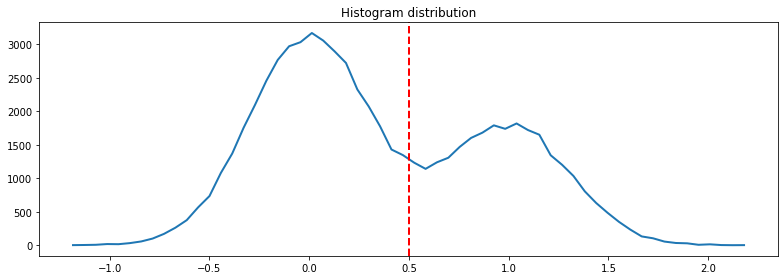

In [24]:
# Plotting histogram
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True,
                       figsize=(11, 4))

ax.plot(bin_centers, hist, lw=2)
ax.axvline(0.5, color='r', ls='--', lw=2)
ax.set_title('Histogram distribution')

plt.tight_layout()
plt.show()

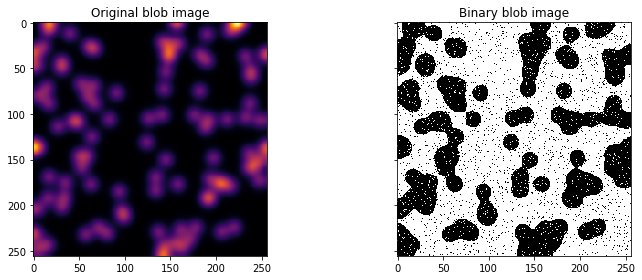

In [25]:
# Plotting segmentation
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,
                       figsize=(11, 4))

ax[0].imshow(im, cmap=plt.cm.inferno)
ax[0].set_title('Original blob image')

ax[1].imshow(binary_img, cmap=plt.cm.gray)
ax[1].set_title('Binary blob image')

plt.tight_layout()
plt.show()

### Using mathematical morphology to clean segmentation

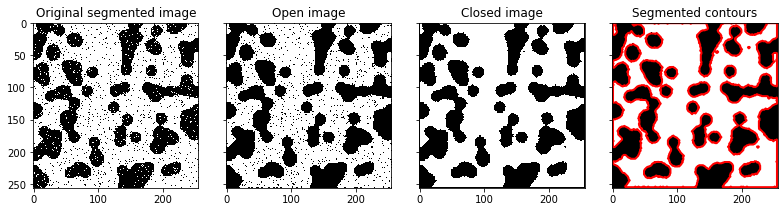

In [26]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

# Remove small white regions
open_img = ndimage.binary_opening(binary_img)

# Remove small black hole
close_img = ndimage.binary_closing(open_img)

# Plotting segmentation
fig, ax = plt.subplots(ncols=4, sharex=True, sharey=True,
                       figsize=(11, 4))

ax[0].imshow(binary_img, cmap=plt.cm.gray)
ax[0].set_title('Original segmented image')

ax[1].imshow(open_img, cmap=plt.cm.gray)
ax[1].set_title('Open image')

ax[2].imshow(close_img, cmap=plt.cm.gray)
ax[2].set_title('Closed image')

ax[3].imshow(close_img, cmap=plt.cm.gray)
ax[3].contour(close_img, [0.5], linewidths=2, colors='r')
ax[3].set_title('Segmented contours')

plt.tight_layout()
plt.show()

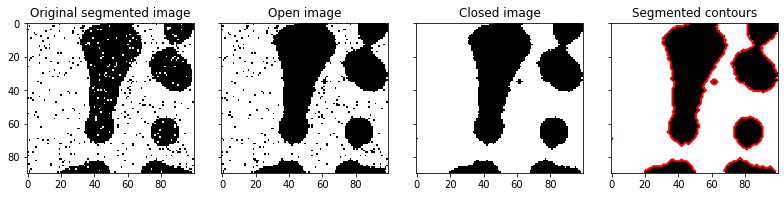

In [27]:
# Plotting segmentation
fig, ax = plt.subplots(ncols=4, sharex=True, sharey=True,
                       figsize=(11, 4))

ax[0].imshow(binary_img[10:100, 100:200], cmap=plt.cm.gray)
ax[0].set_title('Original segmented image')

ax[1].imshow(open_img[10:100, 100:200], cmap=plt.cm.gray)
ax[1].set_title('Open image')

ax[2].imshow(close_img[10:100, 100:200], cmap=plt.cm.gray)
ax[2].set_title('Closed image')

ax[3].imshow(close_img[10:100, 100:200], cmap=plt.cm.gray)
ax[3].contour(close_img[10:100, 100:200], [0.5], linewidths=2, colors='r')
ax[3].set_title('Segmented contours')

plt.tight_layout()
plt.show()

### In class exercise: segmentation

Given the following code and images. Try to select the appropiate segmentation, and use opening and closing filters to fix the noise. As well, apply some contour lines to define the finalized segmentation. Try to apply some high pass and low pass filters to see how it affects histogram segmentation.

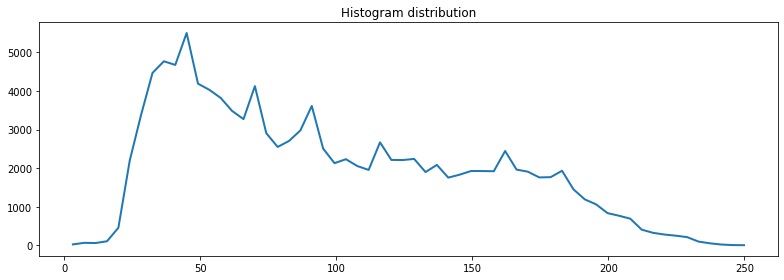

In [28]:
from scipy import ndimage
import matplotlib.pyplot as plt

from skimage.data import coins

image_coins = coins()

# Histogram
hist, bin_edges = np.histogram(image_coins, bins=60)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])

# Plotting histogram
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True,
                       figsize=(11, 4))

ax.plot(bin_centers, hist, lw=2)
ax.set_title('Histogram distribution')

plt.tight_layout()
plt.show()

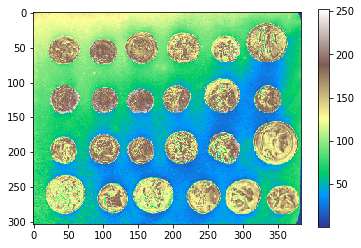

In [29]:
import matplotlib.pyplot as plt
plt.imshow(image_coins, cmap=plt.cm.terrain)
plt.colorbar()
plt.show()

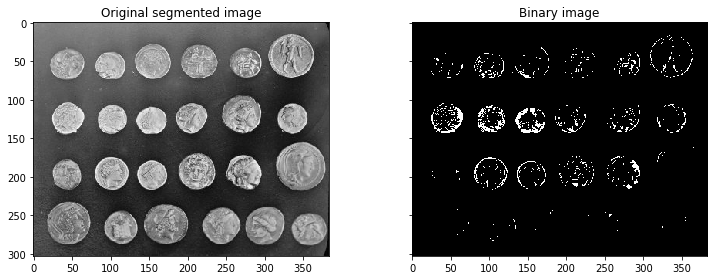

In [30]:
import imageio
from scipy import ndimage
import matplotlib.pyplot as plt

from skimage.data import coins

image_coins = coins()
binary_coins = image_coins > 200

# Plotting segmentation
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,
                       figsize=(11, 4))

ax[0].imshow(image_coins, cmap=plt.cm.gray)
ax[0].set_title('Original segmented image')

ax[1].imshow(binary_coins, cmap=plt.cm.gray)
ax[1].set_title('Binary image')

plt.tight_layout()
plt.show()

# Scikit image: streamlining Python image processing

Scikit-image is an advanced library for image processing in Python. It is currently included in the SciPy ecosystem. 

Many examples of its usage are available at the [scikit-image](https://scikit-image.org)

Within scikit-image, we can find different kinds of functions that streamline our image processing capabilities, from boilerplate utility functions to high-level recent algorithms.

* Filters: functions transforming images into other images.

    * NumPy machinery
    * Common filtering algorithms
* Data reduction functions: computation of image histogram, position of local maxima, of corners, etc.

* Other actions: I/O, visualization, etc.

## Data packaged into scikit image

Scikit image comes with an [in-built dataset](https://scikit-image.org/docs/dev/api/skimage.data.html) for doing our tests, we can access it and use it as follows:

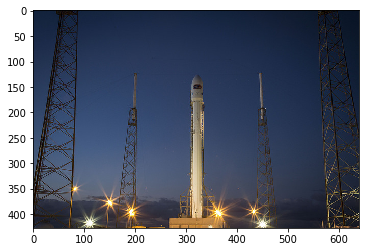

In [31]:
import skimage
import matplotlib.pyplot as plt
from skimage import data  # most functions are in subpackages

rocket = data.rocket()

plt.imshow(rocket)
plt.show()

### Accessing channels with NumPy

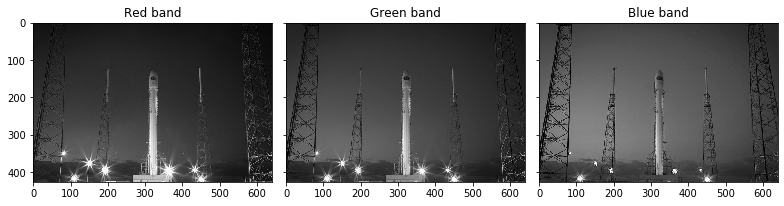

In [32]:
import skimage
import matplotlib.pyplot as plt
from skimage import data  # most functions are in subpackages
from skimage.io import imsave

rocket = data.rocket()

# Plotting segmentation
fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True,
                       figsize=(11, 4))

ax[0].imshow(rocket[:,:,0], cmap=plt.cm.gray)
ax[0].set_title('Red band')

ax[1].imshow(rocket[:,:,1], cmap=plt.cm.gray)
ax[1].set_title('Green band')

ax[2].imshow(rocket[:,:,2], cmap=plt.cm.gray)
ax[2].set_title('Blue band')

plt.tight_layout()
plt.show()

### Turn data into grayscale

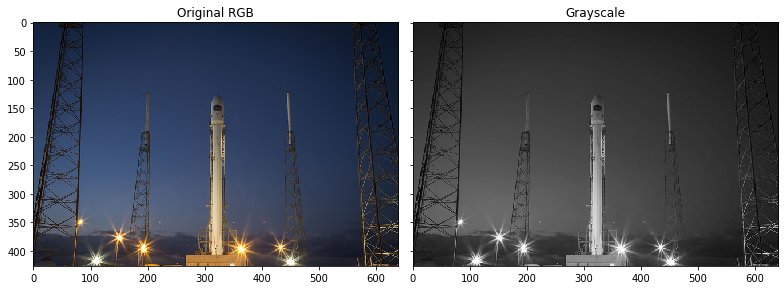

In [33]:
import skimage
import matplotlib.pyplot as plt
from skimage import data  # most functions are in subpackages
from skimage.io import imsave
from skimage.color import rgb2gray


rocket = data.rocket()
grayscale = rgb2gray(rocket)

# Plotting segmentation
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,
                       figsize=(11, 4))

ax[0].imshow(rocket)
ax[0].set_title('Original RGB')

ax[1].imshow(grayscale, cmap=plt.cm.gray)
ax[1].set_title('Grayscale')

plt.tight_layout()
plt.show()

## IO: beyond imageio

Scikit-image has an in built io method. And we can read and save from files:

<function matplotlib.pyplot.show(*args, **kw)>

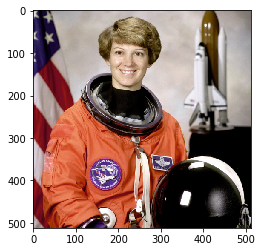

In [34]:
from skimage import data  # most functions are in subpackages
from skimage.io import imsave
import matplotlib.pyplot as plt

astronaut = data.astronaut()
imsave("astronaut.jpeg", astronaut)

plt.imshow(astronaut)
plt.show

### Goodbye matplotlib! (Not quite)

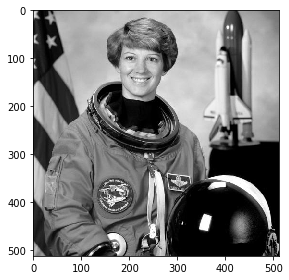

In [35]:
from skimage.io import imread, imshow

astronaut_loaded = imread("astronaut.jpeg", as_gray=True)
imshow(astronaut_loaded)

## More coordinate conventions!

Because scikit-image represents images using NumPy arrays, the coordinate conventions must match. Two-dimensional (2D) grayscale images (such as camera above) are indexed by rows and columns (abbreviated to either (row, col) or (r, c)), with the lowest element (0, 0) at the top-left corner. In various parts of the library, you will also see rr and cc refer to lists of row and column coordinates. We distinguish this convention from (x, y), which commonly denote standard Cartesian coordinates, where x is the horizontal coordinate, y - the vertical one, and the origin is at the bottom left (Matplotlib axes, for example, use this convention).

In the case of multichannel images, the last dimension is used for color channels and is denoted by channel or ch.

Finally, for volumetric (3D) images, such as videos, magnetic resonance imaging (MRI) scans, confocal microscopy, etc. we refer to the leading dimension as plane, abbreviated as pln or p.

**Image type and coordinates**

* 2D grayscale (row, col)

* 2D multichannel (eg. RGB) (row, col, ch)

* 3D grayscale (pln, row, col)

* 3D multichannel (pln, row, col, ch)


##  Color manipulation

We can represent different color spaces using the submodule `skimage.color`. 

Color spaces are very important since some computer vision tasks are better suited with other tipe of color spaces such as HSV (Hue, Saturation, Value) or CYMK, which is used for printing.

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/3/33/HSV_color_solid_cylinder_saturation_gray.png/197px-HSV_color_solid_cylinder_saturation_gray.png)

### HSV

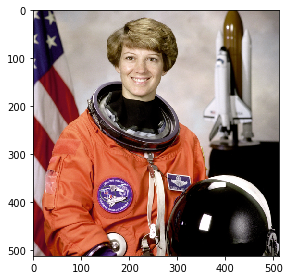

In [36]:
from skimage import data
from skimage.io import imread, imshow  # most functions are in subpackages

astronaut = data.astronaut()

# Normal RGB
imshow(astronaut)

/home/scientist/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:265: RuntimeWarning: divide by zero encountered in true_divide
  out_s = delta / out_v
/home/scientist/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:271: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = (arr[idx, 1] - arr[idx, 2]) / delta[idx]
/home/scientist/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:275: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 2. + (arr[idx, 2] - arr[idx, 0]) / delta[idx]
/home/scientist/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:279: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 4. + (arr[idx, 0] - arr[idx, 1]) / delta[idx]


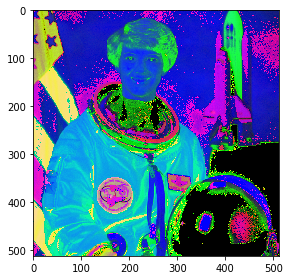

In [37]:
from skimage.color import rgb2hsv

imshow(rgb2hsv(astronaut))

### RGBA
Some images come with an extra band (alpha band) that usually controls transparency. We can remove it in order to ease our analysis.

(500, 500, 4)


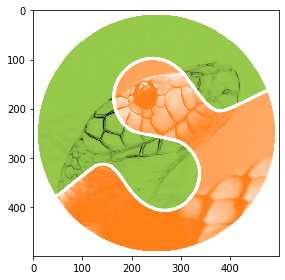

In [38]:
from skimage.color import rgba2rgb
from skimage import data
from skimage.io import imshow

img_rgba = data.logo()
img_rgb = rgba2rgb(img_rgba)

print(img_rgba.shape)
imshow(img_rgba)

(500, 500, 3)


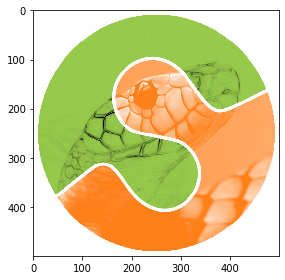

In [39]:
print(img_rgb.shape)
imshow(img_rgb)

### Inverting images
An inverted image is the "negative" of the real image. For binary images, True values become False and conversely. For grayscale images, pixel values are replaced by the difference of the maximum value of the data type and the actual value. For RGB images, the same operation is done for each channel. 

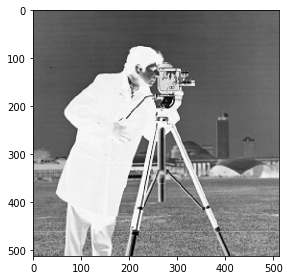

In [40]:
from skimage.io import imshow
from skimage import data
from skimage import util
img = data.camera()
inverted_img = util.invert(img)

imshow(inverted_img)

### Manipulating contrast and exposure
Scikit image comes with a contrast enhancer built in, `rescale_intensity()` which consists in stretching pixel values to the whole allowed range, using a linear transformation.



10 197


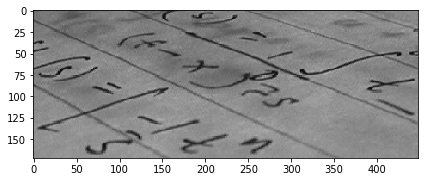

In [41]:
from skimage.io import imshow
from skimage import data
from skimage import exposure
text = data.text()
print(text.min(), text.max())
imshow(text)

0 255


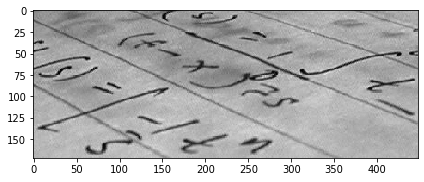

In [42]:
better_contrast = exposure.rescale_intensity(text)
print(better_contrast.min(), better_contrast.max())
imshow(better_contrast)

### Histogram equalization

When images have low contrast, we need to do some enhancement such as histogram equalization to evenly spread the intensity values.

The function `equalize_hist()` maps the cumulative distribution function (cdf) of pixel values onto a linear cdf, ensuring that all parts of the value range are equally represented in the image. As a result, details are enhanced in large regions with poor contrast. As a further refinement, histogram equalization can be performed in subregions of the image with `equalize_adapthist()`, in order to correct for exposure gradients across the image.

The problem is that sometimes, histogram equalization yields rather unnatural images, then we can use contrast stretching to have more natural looking images. We can do this using some percentiles and applying the `rescale_intensity()` function.



In [43]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, img_as_float
from skimage import exposure


matplotlib.rcParams['font.size'] = 8


def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

In [44]:
# Load an example image
img = data.moon()

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

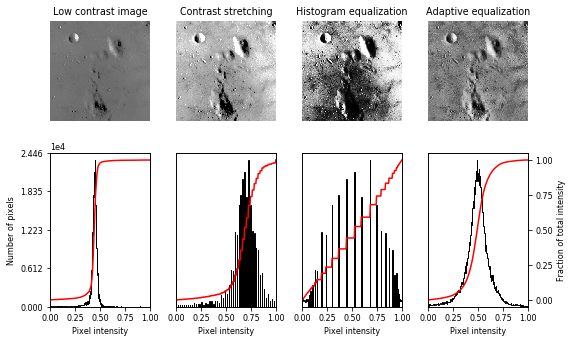

In [45]:
# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

## Segmentation with Scikit image

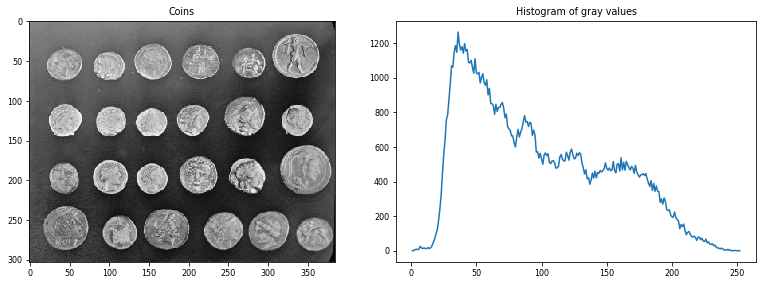

In [46]:
from skimage import data
from skimage.exposure import histogram

coins = data.coins()
hist, hist_centers = histogram(coins)

# Plotting segmentation
fig, ax = plt.subplots(ncols=2, sharex=False, sharey=False,
                       figsize=(11, 4))

ax[0].imshow(coins, cmap=plt.cm.gray)
ax[0].set_title('Coins')

ax[1].plot(hist_centers, hist)
ax[1].set_title('Histogram of gray values')

plt.tight_layout()
plt.show()

### A naive approach to segmentation

Simply thresholding the image leads either to missing significant parts of the coins, or to merging parts of the background with the coins. This is due to the inhomogeneous lighting of the image.



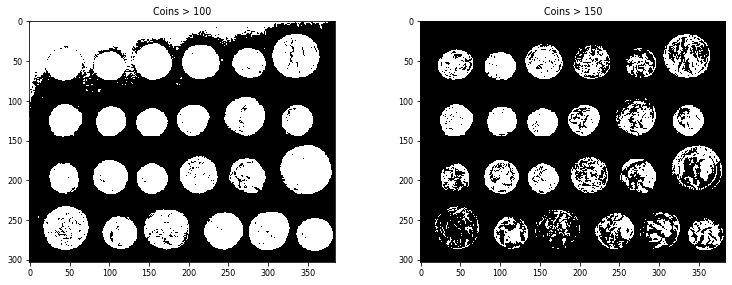

In [47]:
from skimage import data
from skimage.exposure import histogram

coins = data.coins()

coins_100 = coins > 100

coins_150 = coins > 150

# Plotting segmentation
fig, ax = plt.subplots(ncols=2, sharex=False, sharey=False,
                       figsize=(11, 4))

ax[0].imshow(coins_100, cmap=plt.cm.gray)
ax[0].set_title('Coins > 100')

ax[1].imshow(coins_150, cmap=plt.cm.gray)
ax[1].set_title('Coins > 150')

plt.tight_layout()
plt.show()

### Using a more intelligent approach: edge based segmentation
We can take advantage of the local contrast, looking at the edges that enclose the coins. We can use an edge detector like canny, or use the filter Sobel that we already know. 

**Sobel detection** refers to computing the gradient magnitude of an image using 3x3 filters. Where "gradient magnitude" is, for each a pixel, a number giving the absolute value of the rate of change in light intensity in the direction that maximizes this number.

**Canny edge detection** can be understood as an intelligent thresholding of a Saobel filter. It actually goes a bit further by removing **speckle noise** with a **low pass filter** first, then applying a **Sobel filter**, and then doing [**non-maximum suppression**](https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c) to pick out the best pixel for edges when there are multiple possibilities in a local neighborhood. 



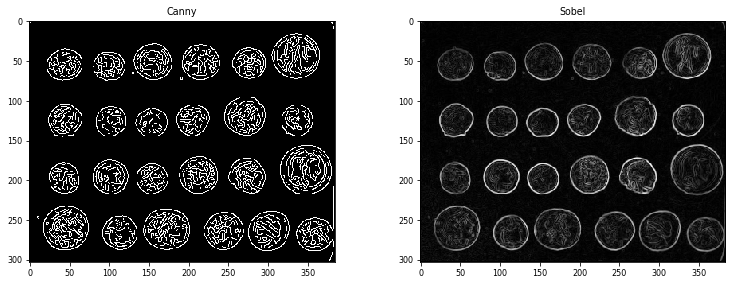

In [48]:
from skimage import data
from skimage.feature import canny
from skimage.filters import sobel

coins = data.coins()

canny_coins = canny(coins/255.)

sobel_coins = sobel(coins)

# Plotting segmentation
fig, ax = plt.subplots(ncols=2, sharex=False, sharey=False,
                       figsize=(11, 4))

ax[0].imshow(canny_coins, cmap=plt.cm.gray)
ax[0].set_title('Canny')

ax[1].imshow(sobel_coins, cmap=plt.cm.gray)
ax[1].set_title('Sobel')

plt.tight_layout()
plt.show()

### Using mathematical morphology to fill the holes

We could use the `scipy.ndimage `closing to fill the holes, but actually scipy comes also packaged already with `binary_fill_holes` which does a similar operation

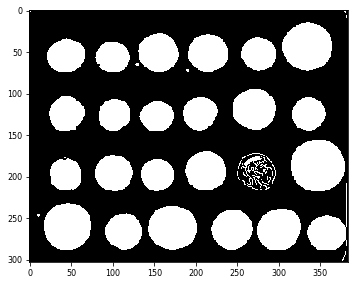

In [49]:
from skimage.io import imshow

from scipy import ndimage as ndi
fill_coins = ndi.binary_fill_holes(canny_coins)
imshow(fill_coins)

### Removing small objects
Most of the coins have been segmented from the background. However there are some objects from the background that needs to be removed. We can use the ndimage from scipy to label the objects that are smaller than certain threshold:

113


/home/scientist/anaconda3/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


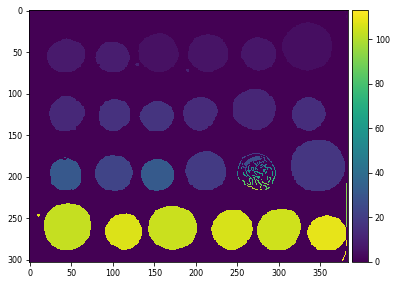

In [50]:
# we call the label function
label_objects, nb_labels = ndi.label(fill_coins)
print(nb_labels)
imshow(label_objects)

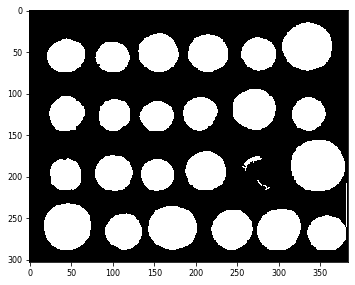

In [51]:
# We calculate the size of isolated objects.
"""
We should have 24 objects (24 coins) but we actually have 113!
That is due to the small objects of the bad segmented coin, so we can mask based 
on size.
"""
# We get the sizes for each object
sizes = np.bincount(label_objects.ravel())

# Then, we mask everything that is above 20 to try to get most of coins
mask_sizes = sizes > 20
mask_sizes[0] = 0

# We apply the mask to label objects
coins_cleaned = mask_sizes[label_objects]

imshow(coins_cleaned)

### Region based segmentation
The problem with canny edge detector is that sometimes it does not close the shapes. And then the filling function did not perform correctly. We could finalize the segmentation by doing some opening and closing, but it will be too "handcrafted".

We can go ahead and try with some region based segmentation.

Let us first determine markers of the coins and the background. These markers are pixels that we can label unambiguously as either object or background. Here, the markers are found at the two extreme parts of the histogram of grey values

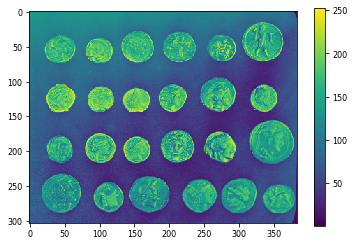

In [52]:
import matplotlib.pyplot as plt
plt.imshow(coins)
plt.colorbar()
plt.show()

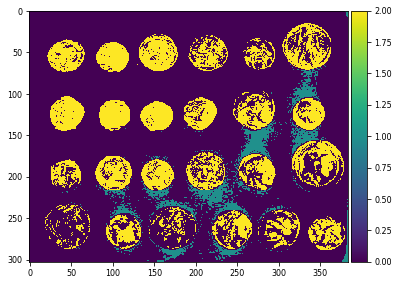

In [53]:
# Let's create a zeros array with the same shape as coins
markers = np.zeros_like(coins)

# When the pixels are below 30 (see image above), we can label as background(1)
markers[coins < 30] = 1

# When the pixels are above 150 (see image above), we can label as coins(2)
markers[coins > 150] = 2
imshow(markers)

### Using a watershed algorithm

We will use these markers in a watershed segmentation. The name watershed comes from an analogy with hydrology. The watershed transform floods an image of elevation starting from markers, in order to determine the catchment basins of these markers. Watershed lines separate these catchment basins, and correspond to the desired segmentation.

The choice of the elevation map is critical for good segmentation. Here, the amplitude of the gradient provides a good elevation map. We use the Sobel operator for computing the amplitude of the gradient

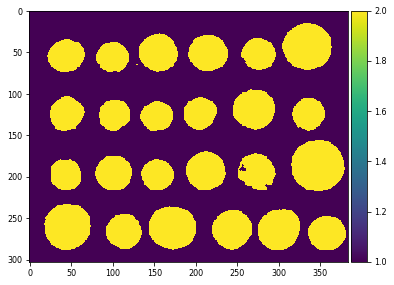

In [54]:
from skimage.morphology import watershed
segmentation_ = watershed(sobel_coins, markers)
imshow(segmentation_)

### Removing some easy holes using mathematical morphology

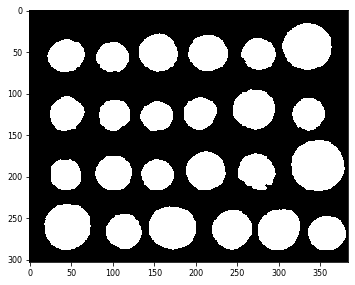

In [55]:
# Remove the background values before filling!
from skimage.io import imshow

segmentation_treshold = ndi.binary_fill_holes(segmentation_ - 1)
seg_mimadre = ndi.binary_opening(segmentation_treshold)
imshow(seg_mimadre)

In [61]:
seg_mimadre

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

### Add the labels again!
How many labels we have? Why?

24


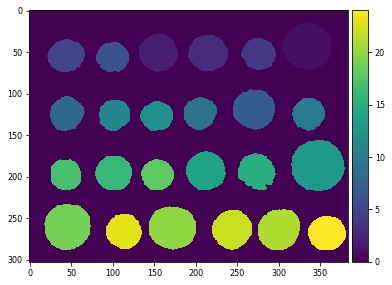

In [56]:
labeled_coins, _ = ndi.label(seg_mimadre)
print(_)
imshow(labeled_coins)

## In class exercise: counting connected blobs
Segment the image below and count the connected blobs

<class 'numpy.ndarray'>
(512, 512)


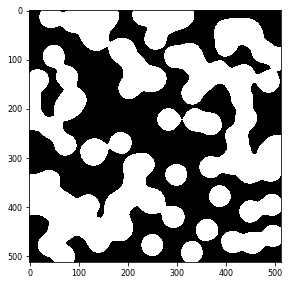

In [57]:
from skimage.io import imshow
from skimage import data

img = data.binary_blobs()
imshow(img)
print(type(img))
print(img.shape)

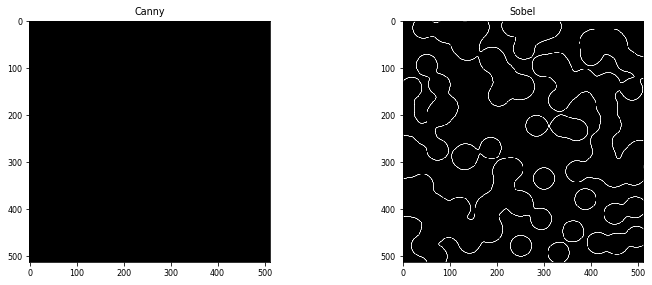

In [58]:
from skimage import data
from skimage.feature import canny
from skimage.filters import sobel

canny_img = canny(img/255.)

sobel_img = sobel(img)

# Plotting segmentation
fig, ax = plt.subplots(ncols=2, sharex=False, sharey=False,
                       figsize=(11, 4))

ax[0].imshow(canny_img, cmap=plt.cm.gray)
ax[0].set_title('Canny')

ax[1].imshow(sobel_img, cmap=plt.cm.gray)
ax[1].set_title('Sobel')

plt.tight_layout()
plt.show()

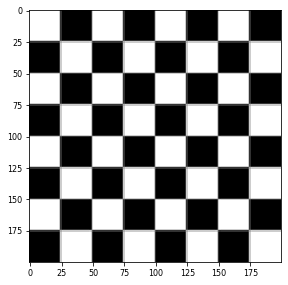

In [59]:
from skimage.io import imshow
from skimage import data

img = data.checkerboard()
imshow(img)

## Upload your own picture

In [60]:
from skimage.io import imread, imshow

pens = imread("/content/IMG_20191017_132005_758.jpg", as_gray=True)
imshow(pens)

FileNotFoundError: [Errno 2] No such file or directory: '/content/IMG_20191017_132005_758.jpg'

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(pens)
plt.colorbar()
plt.show()

In [ ]:
# Let's create a zeros array with the same shape as coins
markers = np.zeros_like(pens)

# When the pixels are below 30 (see image above), we can label as background(1)
markers[pens < 0.2] = 1

# When the pixels are above 150 (see image above), we can label as coins(2)
markers[pens > 0.4] = 2
imshow(markers)

In [ ]:
from skimage.filters import sobel

sobel_pens = sobel(pens)
imshow(sobel_pens)

In [ ]:
from skimage.morphology import watershed
segmentation = watershed(sobel_pens, markers)
imshow(segmentation)

In [ ]:
# Remove the background values before filling!
from skimage.io import imshow

segmentation_treshold = ndi.binary_fill_holes(segmentation-1)
segmentation_opening = ndi.binary_opening(segmentation_treshold, structure=np.ones((5,5)))
segmentation_closing = ndi.binary_closing(segmentation_opening, structure=np.ones((5,5)))
imshow(segmentation_closing)

In [ ]:
from scipy import ndimage as ndi

labeled_pens, number_pens = ndi.label(segmentation_opening)
print(number_pens)
imshow(labeled_pens)